
The film industry is a complicated and fascinating multi-billion dollar market. In this notebook, I build a model that uses information about movie trailer viewership (online search trends, etc) and other movie metadata to predict the initial ROI of a movie. 

**Target:** The target variable, which I label as "success", is defined as

$success = \frac{opening \ weekend \ revenue}{budget}$

**Data Description (inputs):**
* title: movie's title.
* num_peaks: number of online search peaks from Google Trends corresponding to a movie trailer. 
* search_volume: area under the curve in the Google trends data (normalized to 100).
* budget: movie's budget (excluding marketing costs, which are typically as large as the budget itself).
* genres: movie's genres.
* original_language: language spoken in the original version of the movie.
* production_companies: movie's list of production companies.
* production_countries: movie's list of production countires (at least one of the must be the US)
* release_date: movie's release data (we only consider movies with release dates after 2009, since data from Youtube and Google trends is more reliable in this range).
* runtime: movie duration in minutes (we restrict to movies with at least 80 minutes long).
* weekend_rev: movie's opening weekend revenue in dollars
* num_theaters: number of theaters screening the movie during opening weekend.
* day: movie's release day (e.g, Mon).
* month: movie's release month (e.g, Jan).
* year: movie's release year (e.g, 2010).
* holiday: binary variable indicating if the release date was during a month with a holiday.
* views: movie's mean number of Youtube trailer views.
* likes: movie's mean number of Youtube trailer likes.
* dislikes: movie's mean number of Youtube trailer dislikes.
* dt_main: number of days between the Youtube trailer with largest search volume and the movie's release date.
* dt_trailers: number of days between the two most popular Youtube trailers for a movie. dt_trailers=0 if the movie only has one trailer, dt_trailers<0 if the first trailer was has the largest search volume.
* dt_trailers_cat: categorical version of dt_trailers describing the sign of dt_trailers.  

**Constraints:** To train our model, we only consider movies
* released after 2010 
* with runtimes > 80 min
* with budget > $ 10,000,000
* with production companies that always include the US

**Contructed Predictors:** To measure positive trailer views we define the 'viewership score':

$viewership\_score = \ln\left(views \times search\_volume \times \frac{likes - dislikes}{likes + dislikes}\right)$


**Results:** We find that the viewership score and the production budget are the main predictors for success of a movie success (as defined above). 

In [1]:
%matplotlib inline
from IPython.display import Image, HTML
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary
import datetime
import ast
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import re, time
import warnings, requests
warnings.filterwarnings('ignore')
#plotly.tools.set_credentials_file(username='', api_key='')

sns.set_style('white')
sns.set(font_scale=1.7)
pd.set_option('display.max_colwidth', 50)

# so that the notebook's output is stable across runs
np.random.seed(42)

## Exploratory Analysis

### Get Data

Let us begin by importing the preprocessed dataset for movies with release year >= 2010. This dataset is an output of the final_data_processing.py script.

In [2]:
df = pd.read_csv('data/df_final.csv')

In [3]:
df.columns

Index(['title', 'num_peaks', 'search_mean', 'search_volume', 'budget',
       'genres', 'original_language', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'weekend_rev',
       'num_theaters', 'success', 'day', 'month', 'holiday', 'year', 'views',
       'likes', 'dislikes', 'dt_main', 'dt_trailers', 'dt_trailers_cat'],
      dtype='object')

In [4]:
df.corr()

,num_peaks,search_mean,search_volume,budget,runtime,weekend_rev,num_theaters,success,holiday,year,views,likes,dislikes,dt_main,dt_trailers
num_peaks,1.000000,0.659220,0.660293,-0.090667,-0.057474,-0.115106,-0.168924,-0.135409,-0.005508,-0.062876,-0.056151,-0.066285,-0.055864,0.164708,0.152927
search_mean,0.659220,1.000000,0.999215,-0.033524,-0.012452,-0.037299,-0.037113,-0.070647,-0.028445,-0.051099,0.003370,-0.028943,-0.026276,0.176107,0.059582
search_volume,0.660293,0.999215,1.000000,-0.027136,-0.012258,-0.033510,-0.033384,-0.070712,-0.029023,-0.046673,0.005787,-0.024723,-0.025353,0.179077,0.058338
budget,-0.090667,-0.033524,-0.027136,1.000000,0.268034,0.638513,0.566100,-0.084779,-0.102136,-0.032068,0.182431,0.221011,0.155985,0.135846,-0.170116
runtime,-0.057474,-0.012452,-0.012258,0.268034,1.000000,0.135838,0.025121,-0.111369,0.098353,0.142127,-0.004470,0.027156,0.004844,-0.015357,-0.031220
weekend_rev,-0.115106,-0.037299,-0.033510,0.638513,0.135838,1.000000,0.703478,0.305695,-0.162299,-0.079691,0.087509,0.144457,0.017771,0.093818,-0.173165
num_theaters,-0.168924,-0.037113,-0.033384,0.566100,0.025121,0.703478,1.000000,0.316171,-0.117101,-0.068394,0.045345,0.082915,0.003385,0.000392,-0.142930
success,-0.135409,-0.070647,-0.070712,-0.084779,-0.111369,0.305695,0.316171,1.000000,0.015419,-0.116226,0.047513,0.032664,-0.012641,-0.034232,0.002489
holiday,-0.005508,-0.028445,-0.029023,-0.102136,0.098353,-0.162299,-0.117101,0.015419,1.000000,0.003123,0.019026,-0.001806,-0.048411,0.050931,-0.026448
year,-0.062876,-0.051099,-0.046673,-0.032068,0.142127,-0.079691,-0.068394,-0.116226,0.003123,1.000000,0.040758,0.130598,0.078493,0.073287,-0.071415


In [5]:
df.corr()['success'].sort_values(ascending = False)

success          1.000000
num_theaters     0.316171
weekend_rev      0.305695
views            0.047513
likes            0.032664
holiday          0.015419
dt_trailers      0.002489
dislikes        -0.012641
dt_main         -0.034232
search_mean     -0.070647
search_volume   -0.070712
budget          -0.084779
runtime         -0.111369
year            -0.116226
num_peaks       -0.135409
Name: success, dtype: float64

We see that features such as likes, views and dislikes are somewhat correlated with weekend revenue.


### Youtube views, likes, dislikes

Let us work with logs since these variables span several oreders of magnitude

In [6]:
df['log_dislikes'] = df[df.dislikes!=0].dislikes.apply(np.log)
df['log_likes'] = df[df.likes!=0].likes.apply(np.log)
df['log_views'] = df[df.views!=0].views.apply(np.log)
df['log_weekend_rev'] = df.weekend_rev.apply(np.log)

There is a moderate linear correlation between the log(views) and log(weekend_rev)

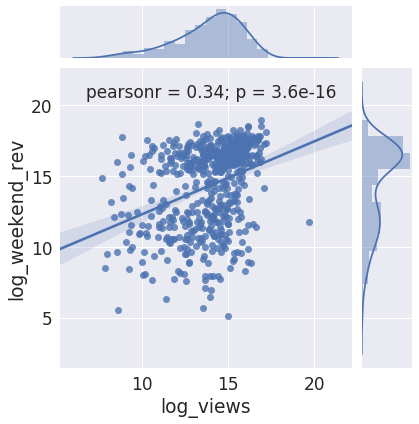

In [7]:
p = sns.jointplot('log_views', 'log_weekend_rev', data=df, kind="reg")
plt.show()

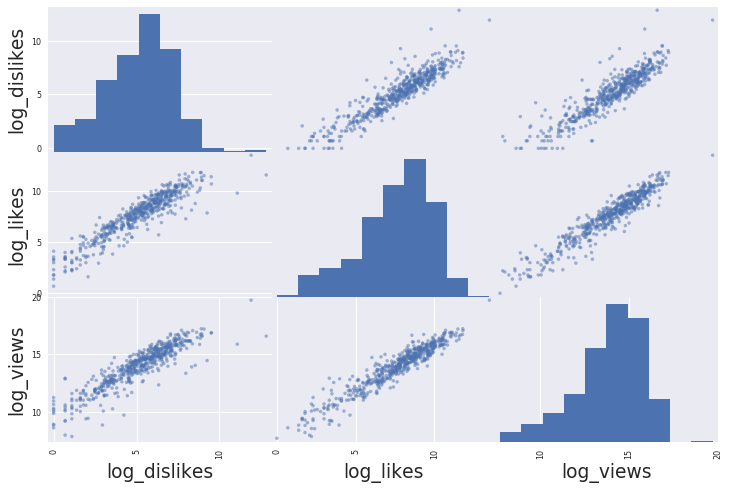

In [8]:
from pandas.tools.plotting import scatter_matrix

attributes = ['log_dislikes', 'log_likes', 'log_views']
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

We see that the logs of likes, dislikes and views are highly correlated. We can therefore use only one of these feature when building a machine learning model.

### Production Countries

In [9]:
# create list that includes all countries involved in the movie data set
countries = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
countries.name = 'countries'

countries_df = df.drop('production_countries', axis=1).join(countries)
countries_df = pd.DataFrame(countries_df['countries'].value_counts())
countries_df['country'] = countries_df.index
countries_df.columns = ['num_movies', 'country']
countries_df = countries_df.reset_index().drop('index', axis=1)
countries_df.head(10)
countries_df = countries_df[countries_df['country'] != 'United States of America']

countries_df.head()

,num_movies,country
0,400,['United States of America']
1,24,"['United Kingdom', 'United States of America']"
2,16,"['Canada', 'United States of America']"
3,7,"['France', 'United States of America']"
4,4,"['Australia', 'United States of America']"


### Production Studios

Let us see what are the top production companies (with largest average "success" per movies they produce)

In [10]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

com_df = df.drop('production_companies', axis=1).join(s)

com_sum = pd.DataFrame(com_df.groupby('companies')['success'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['success'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['success'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

com_mean.head()

,Average
companies,
Solana Films,9.957961
Haunted Movies,8.847643
Room 101,8.157205
Possessed Pictures,6.002545
Extension 765,5.589596


Seems like studios that produce predominantly horror films have large success rates. We will explore this more below when we look into the genres.

### Release Date

Is there a relation between release dates and success?

In [11]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

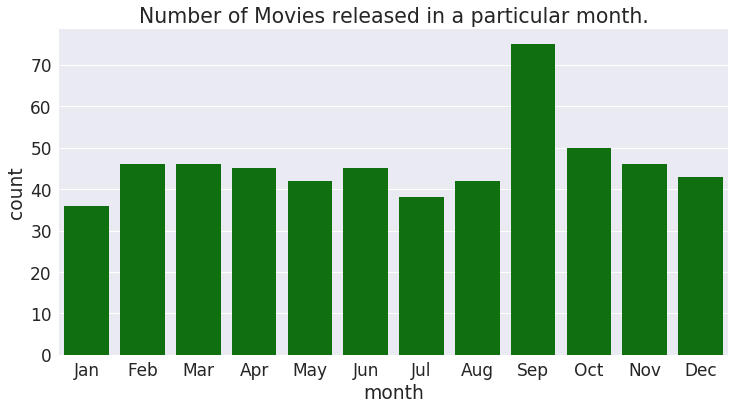

In [12]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df, order=month_order, color='green')

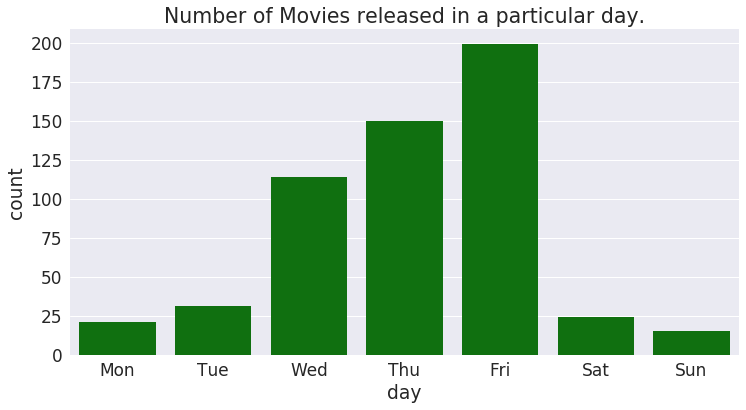

In [13]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular day.")
sns.countplot(x='day', data=df, order=day_order, color='green')

(0, 1.75)

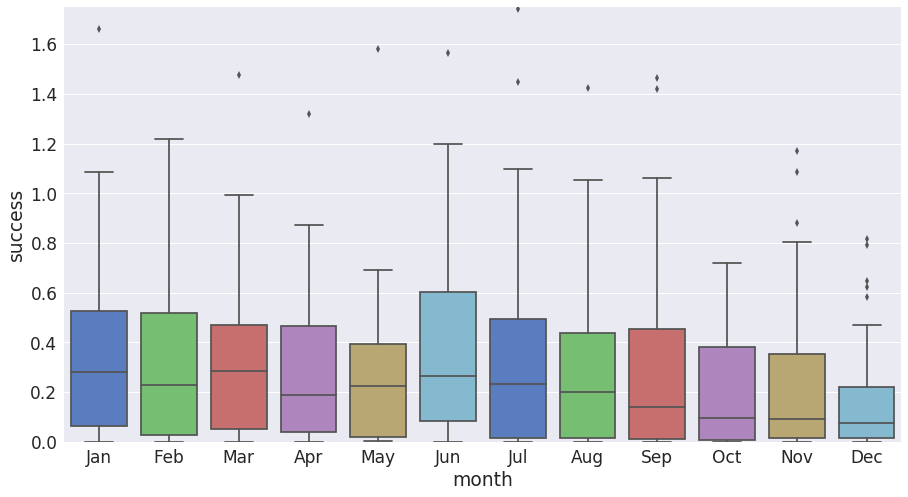

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='month', y='success', data=df[df['success'].notnull()], palette="muted", ax =ax, order=month_order)
ax.set_ylim([0, 1.75])

Seems like movies released in June do better

### Budget

Let us explore the budget feature. We will consider films which were released in at least 1000 theaters during opening weekend.

In [15]:
df['budget'].describe()

count    5.540000e+02
mean     3.807791e+07
std      4.286572e+07
min      1.030064e+06
25%      9.000000e+06
50%      2.000000e+07
75%      5.000000e+07
max      2.090000e+08
Name: budget, dtype: float64

Text(0.5,0,'Budget Distribution (dollars)')

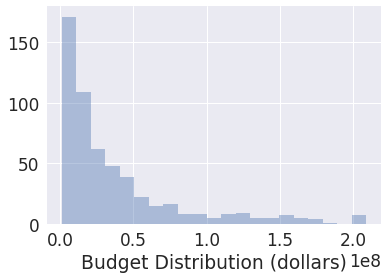

In [16]:
p = sns.distplot(df[df['budget'].notnull()]['budget'], kde=False)
p.set_xlabel('Budget Distribution (dollars)')

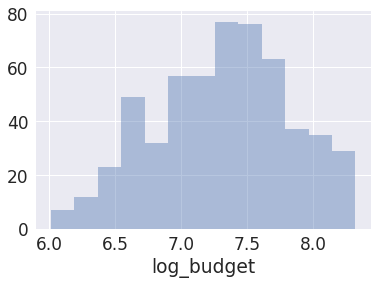

In [17]:
df['log_budget']= df['budget'].apply(np.log10)
sns.distplot(df[df['log_budget'].notnull()]['log_budget'], kde=False)

The log of the budget seems to be sort of normally distributed.

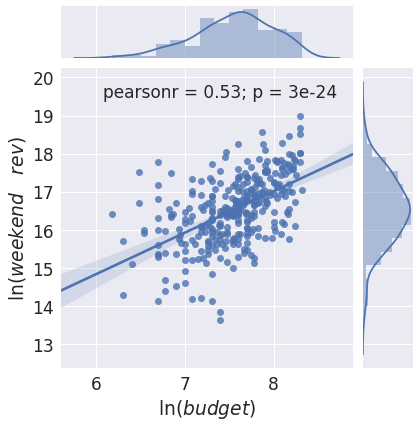

In [18]:
#budget and weekend revenue correlation
p=sns.jointplot('log_budget', 'log_weekend_rev', data=df[df.num_theaters>1000], kind='reg')
p.set_axis_labels(r'$\ln(budget)$', r'$\ln(weekend\quad rev)$')
plt.show()

As expected, budget and weekend revenue are positively correlated.

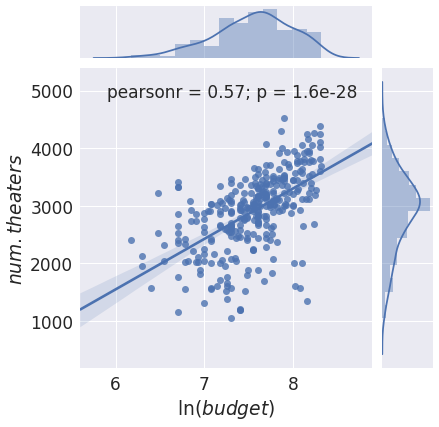

In [19]:
#budget and number of theaters correlation
p=sns.jointplot('log_budget', 'num_theaters', data=df[df.num_theaters>1000], kind='reg')
p.set_axis_labels(r'$\ln(budget)$', r'$num. theaters$')
plt.show()

We see that, in general, large budget films are released in many theaters.

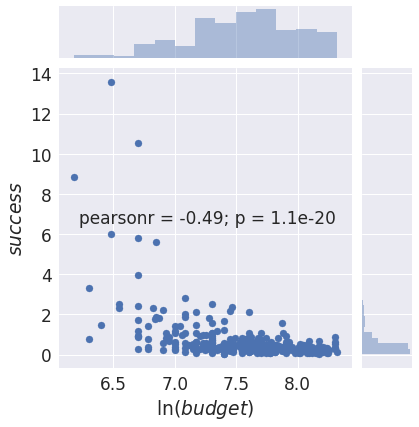

In [20]:
#budget and success correlation
p=sns.jointplot('log_budget', 'success', data=df[df.num_theaters>1000])
p.set_axis_labels(r'$\ln(budget)$', r'$success$')
plt.show()

Surprisingly, there are several movies with smaller budgets that have higher 'success' than average. As we now see, these outliers are mostly horror films.

### Genre

Let us explore the movie genres. Does one genre correlate more with success than the rest?

In [21]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

gen_df = df.drop('genres', axis=1).join(s)

gen_df['genre'].value_counts().shape[0]

18

In [22]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,299
1,Comedy,189
2,Thriller,154
3,Action,128
4,Romance,81
5,Adventure,79
6,Crime,66
7,Science Fiction,58
8,Horror,49
9,Family,48


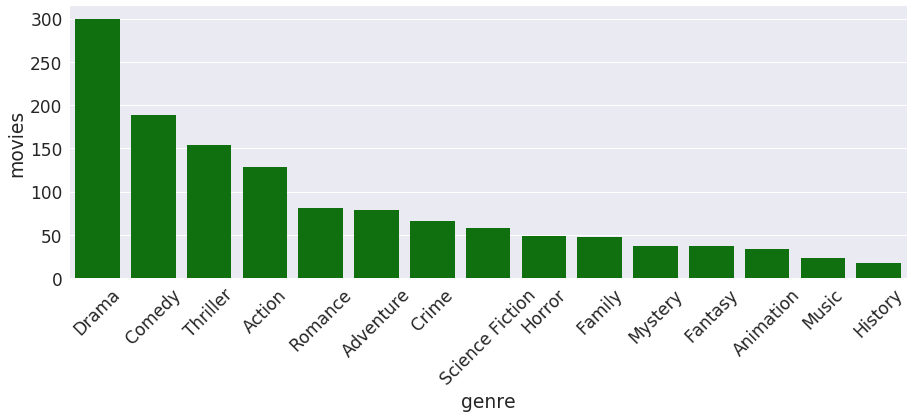

In [23]:
#plot genre distribution 
plt.figure(figsize=(15,5))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15), color='green')
plt.xticks(rotation=45)

plt.show()

In [24]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime',
          'Adventure', 'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

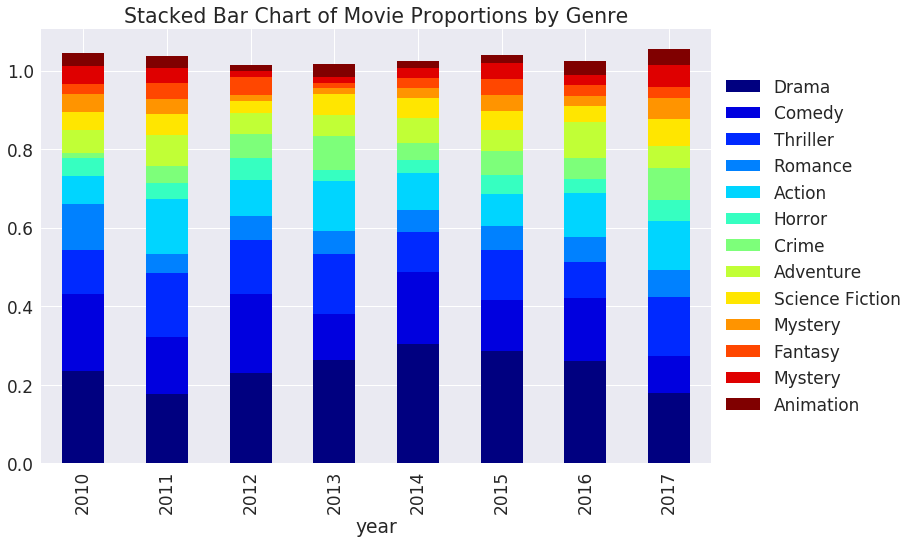

In [25]:
pop_gen_movies = gen_df[(gen_df['genre'].isin(genres))]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Movie Proportions by Genre")
plt.show()

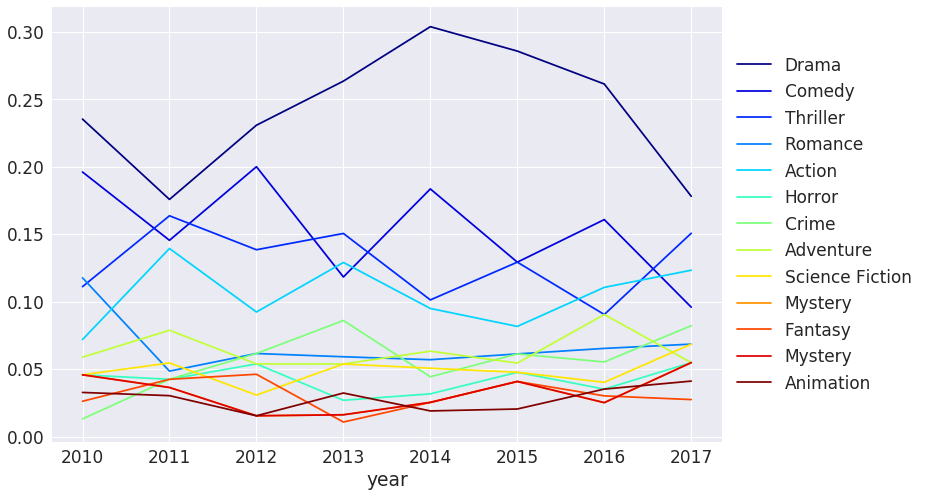

In [26]:
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

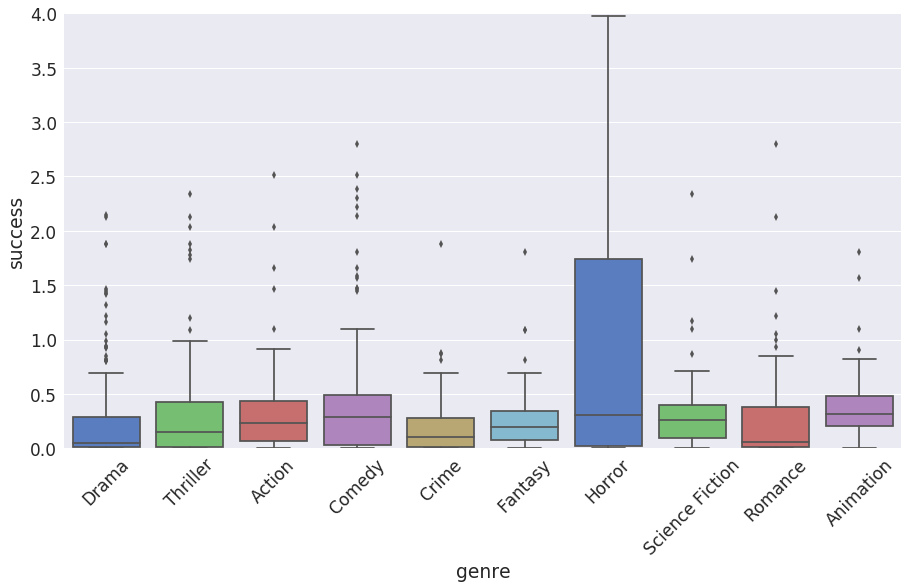

In [28]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='success', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 4])
sns.set(font_scale=1.2)
plt.xticks(rotation=45)
plt.show()

Low budget horror films aparently can lead to success! Indeed, the movie paranormal activity had a budget of 3 million dollars and generated about 40 million on opening weekend:

In [29]:
df.budget[df.title=='Paranormal Activity 2'], df.weekend_rev[df.title=='Paranormal Activity 2'], df.success[df.title=='Paranormal Activity 2']

(359    3000000
 Name: budget, dtype: int64, 359    40678424
 Name: weekend_rev, dtype: int64, 359    13.559475
 Name: success, dtype: float64)

and all of the top 5 movies with largest success are horror films!

In [30]:
pd.DataFrame(df.sort_values('success', ascending=False).title).reset_index(drop=True)[:10]

,title
0,Paranormal Activity 2
1,Paranormal Activity 3
2,Insidious
3,Sinister
4,Paranormal Activity 4
5,Magic Mike
6,Ouija
7,Silent House
8,Think Like a Man
9,Jackass 3D


### runtime

Most movies run for more than 80 minutes. 

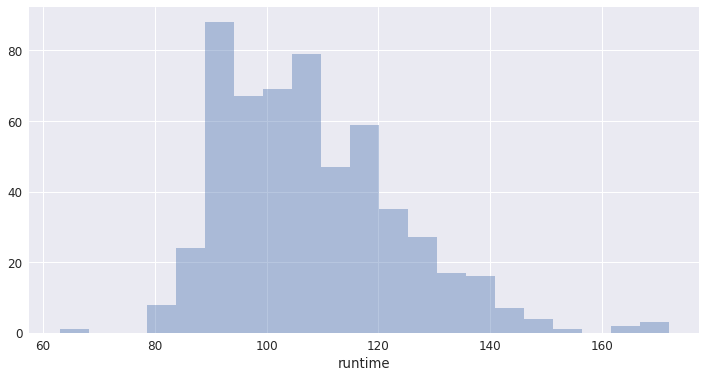

In [31]:
df['runtime'] = df['runtime'].astype('float')
df['runtime'].describe()
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 300) & (df['runtime'] > 0)]['runtime'], kde=False)

## Google trends

Let us explore the google trends data

In [32]:
# import google trends data (for trailer searches)
searches = pd.read_csv('data/searches') #movies released after 2012
searches2010 = pd.read_csv('searches2010')[1:-2] #movies released between 2010-2012
searches = pd.concat([searches2010, searches]).drop_duplicates()

searches.set_index('dates', inplace = True)
searches.drop('dates', inplace = True)

#drop duplicates
searches.reset_index(inplace=True)
searches.drop_duplicates(inplace=True)
searches.set_index('dates', inplace = True)
searches.index = pd.DataFrame(searches.index).apply(
    lambda x: pd.to_datetime(x, format='%Y/%m/%d')).dates

searches.searches = searches.searches.astype(int)

def get_peaks(x,thres, min_dist):
    '''return the indices of the top peaks and their values in the google trends data.
        to be uses when perfoming groupby below'''
    import peakutils
    data = x.values
    baseline_values = peakutils.baseline(data)
    data_without_baseline = data - baseline_values
    peakind = peakutils.indexes(data_without_baseline, thres=thres, min_dist=min_dist)
    dates = x.index
    dates_series = pd.Series(dates)
    data_df = pd.DataFrame(data)
    peak_dates = dates_series[peakind]
    peak_values = data[peakind]
    
    return pd.DataFrame({'peak_dates':peak_dates, 'peak_values':peak_values})

#find the peak index location for each peak
g = searches.groupby('title')
peaks_series = g['searches'].apply(lambda x: get_peaks(x, thres=0.20, min_dist=8))
search_volume = g['searches'].apply(sum)
search_mean = g['searches'].apply(np.mean)

Let us now plot the trends data for the search query for the movie 'gangster squad'

In [33]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy
import peakutils
title = 'Gangster Squad'
dates = searches.groupby('title').groups[title]

def get_movie(title):
    '''function to get google trends data for a particular movie'''
    return searches.loc[searches.title==title]['searches'].copy()

series = pd.Series(get_movie(title).values)
series.set_axis(dates, inplace = True)
indices = list(peaks_series.loc[title].peak_dates.values)

trace = go.Scatter(
    x = dates,
    y= series.values,
    mode='lines',
    name='Search Volume'.format(title)
)

trace2 = go.Scatter(
    x=series[indices].index,
    y=series[indices].values,
    mode='markers',
    marker=dict(
        size=10,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Maxima'
        
)

data = [trace, trace2]
layout = go.Layout(
    title='Search Volume for \"{} trailer\" on  Google Trends '.format(title),
    xaxis=dict(
        title='The year prior to opening weekend',
        titlefont=dict(
            family='Courier New, monospace',
            size=26,
            color='#black'
        ),
        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=20,
            color='black'
        ),
    ),
    yaxis=dict(
        title='Search Volume (Normalized)',
        titlefont=dict(
            family='Courier New, monospace',
            size=26,
            color='black'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
#py.iplot(data, filename=title)
#py.plot(fig, filename='trailers')

The result is

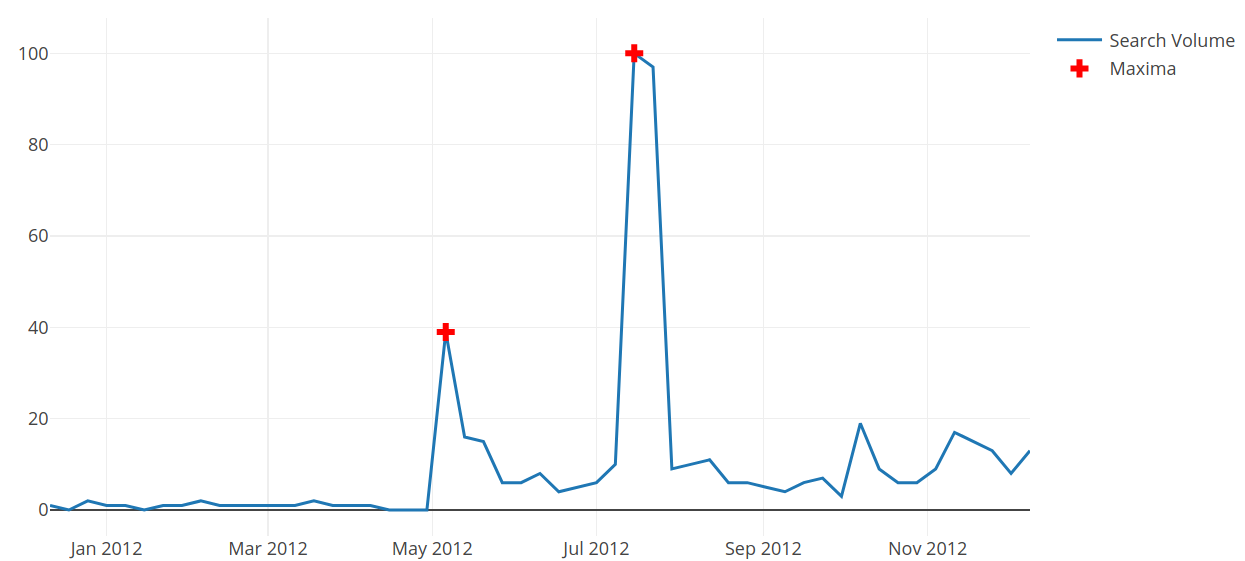

In [34]:
Image(filename='gsquad.png') 

We identify two peaks (search surges) corresponding to two different trailers being released for the movie 'gangster squad'. Note that when running the peak detection algorithm, I assume that the height of the second peak must be at least 20% that of the largest peak in order to qualify as a second trailer (note also that the data from google trends comes normalized to 100).

Here is a question that comes to mind: does it matter in general if the largest peak appears first or second?

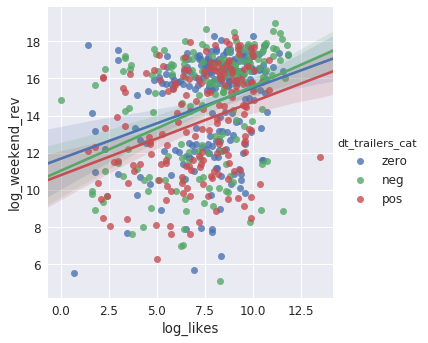

In [35]:
sns.lmplot(x="log_likes", y="log_weekend_rev", hue="dt_trailers_cat", data=df);

In the above plot, the 3 different hues come from the 'dt_trailers_cat' field. They are 
* zero if there is only one peak in the data
* neg if sign(date from larger peak - date from smaller peak)<0
* pos if sign(date from larger peak - date from smaller peak)>0

We see from the plot that movies whose first trailer gets the most attention tend generate more total likes than the other way around. Perhaps this is due to an established fan base or strong marketing strategies prior to the first trailer's release. 

(array([171.,   0.,   0.,   0.,   0., 174.,   0.,   0.,   0., 209.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

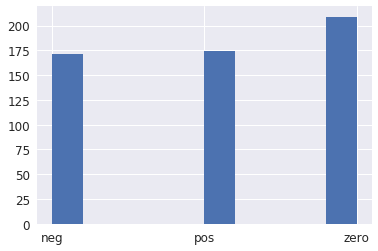

In [36]:
#here is the distribution of dt_trailers_cat
plt.hist(df['dt_trailers_cat'])

The following plot shows that the opening weekend revenue tends  to be higher as well for movies whose first trailer had the most viewership


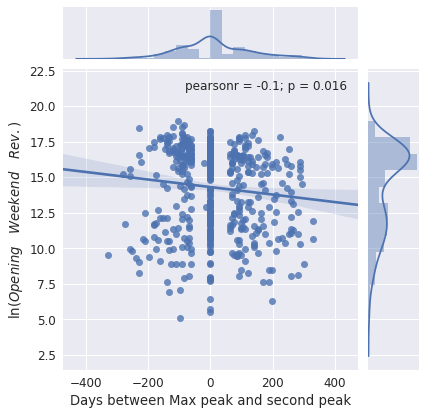

In [37]:
p=sns.jointplot('dt_trailers', 'log_weekend_rev', data=df, kind='reg')
p.set_axis_labels('Days between Max peak and second peak', r'$\ln(Opening\quad Weekend\quad Rev.)$')
plt.show()

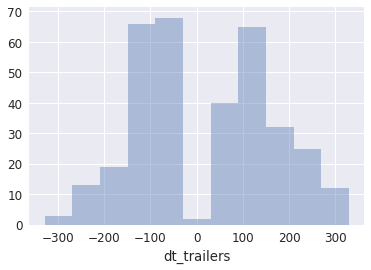

In [38]:
# how many days are there between two trailers?
sns.distplot(df[df['dt_trailers']!=0].dt_trailers, kde=False)

Seems like movie studios tend to release trailers 15 weeks apart.

Text(0.5,0,'Days from best trailer to release date')

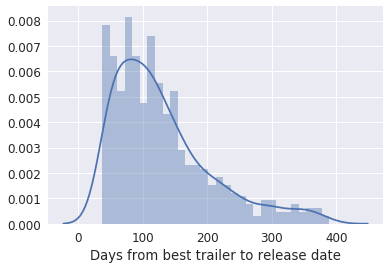

In [39]:
# how many days are there between the best trailer and the relase date?
sns.distplot(df['dt_main'], bins=30)
plt.xlabel('Days from best trailer to release date')

Seems like movie trailers are typically released about 3 months prior to release date.

## Model Building

### Prepare Data Pipeline

Let us import the partially preprocessed data again and prepare it for model ingestion. This includes constraining, dropping and combining features, processing attributes such as genre and production companies, log-transforming numerical attributes with ranges that span several orders of magnitude, feature scaling numerical attributes as well as onehot-encoding categorical ones. 

In [40]:
df = pd.read_csv('data/df_final.csv')

apply constraints

In [41]:
df= df[df.success<=2] #get rid of outliers
df= df[df.budget>=10000000]
df = df[df.num_peaks<3]
df = df[df.runtime>80]

create a trailer viewership score by rescaling views by the (normalized) search volume from google trends and accounting for the likes/dislikes ratio

In [42]:
df.eval('views_rescaled = views*(likes - dislikes)/(likes + dislikes)*search_volume', 
        inplace=True)

divide budget by num_theaters

In [43]:
df.eval('budget_rescaled = budget/num_theaters', inplace=True)

drop these features

In [44]:
df = df.drop(['title', 'search_mean', 'release_date', 'weekend_rev', 'dt_trailers_cat', 
              'runtime', 'likes', 'dislikes', 'views', 'budget', 'num_theaters',
              'num_peaks', 'search_volume'], axis=1)

replace dislikes, likes, views_rescaled, budget and search_volume with their logs

In [45]:
df['viewership_score'] = df[df.views_rescaled!=0].views_rescaled.apply(np.log)
df = df.drop(['views_rescaled'], axis=1)
df['log_budget'] = df[df.budget_rescaled!=0].budget_rescaled.apply(np.log)
df = df.drop(['budget_rescaled'], axis=1)


#drop a few missing values (little effect on model)
df.dropna(inplace=True)

#let us check the data fields
print(df.shape)
df.columns

(260, 13)


Index(['genres', 'original_language', 'production_companies',
       'production_countries', 'success', 'day', 'month', 'holiday', 'year',
       'dt_main', 'dt_trailers', 'viewership_score', 'log_budget'],
      dtype='object')

Let us make some plots. We see that success is largest when log_views is largest and log_budget is lowest.

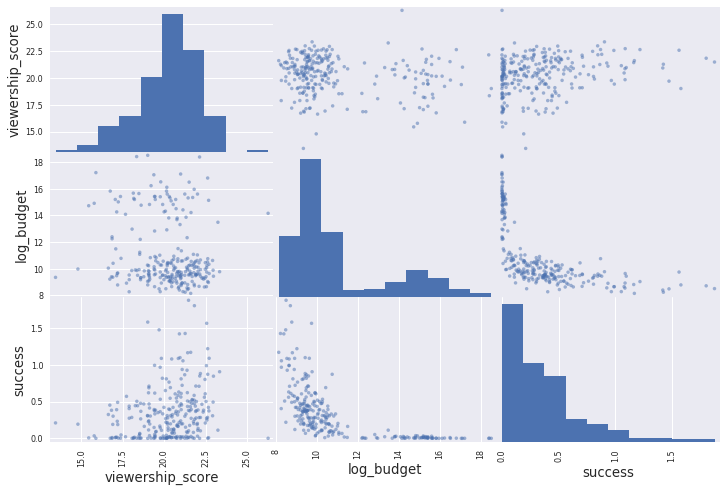

In [46]:
attributes = ['viewership_score', 'log_budget', 'success']
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

Now let us process and binarize the genres attribute

In [47]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)
genres_train = gen_df['genre'].drop_duplicates()
for genre in genres_train:
    df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
df['genres'] = df['genres'].apply(lambda x: len(x))

process production companies

In [48]:
topStudios = list(com_mean.index[:10])
for studio in topStudios:
    df['is_' + str(studio)] = df['production_companies'].apply(lambda x: 1 if studio in x else 0)
df['production_companies'] = df['production_companies'].apply(lambda x: len(x))

process production countries

In [49]:

topCountries = ['United Kingdom', 'United States of America', 'Canada', 'France']  
for country in topCountries:
    df['is_'+str(country)] = df['production_countries'].apply(lambda x: 1 if country in x else 0)
df['production_countries'] = df['production_countries'].apply(lambda x: len(x))

the result is:

In [50]:
df.columns

Index(['genres', 'original_language', 'production_companies',
       'production_countries', 'success', 'day', 'month', 'holiday', 'year',
       'dt_main', 'dt_trailers', 'viewership_score', 'log_budget',
       'is_Adventure', 'is_Drama', 'is_Thriller', 'is_Action', 'is_Comedy',
       'is_Crime', 'is_Fantasy', 'is_Mystery', 'is_Horror',
       'is_Science Fiction', 'is_War', 'is_Family', 'is_Romance', 'is_Music',
       'is_Animation', 'is_Western', 'is_History', 'is_Solana Films',
       'is_Haunted Movies', 'is_Room 101', 'is_Possessed Pictures',
       'is_Extension 765', 'is_Stage 6 Films', 'is_Alliance Films',
       'is_Blumhouse Productions', 'is_White Noise Factory', 'is_Dentsu Inc.',
       'is_United Kingdom', 'is_United States of America', 'is_Canada',
       'is_France'],
      dtype='object')

Now we split data into a training set for validation and a hold-out test set

In [51]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

split numerical and categorical variables

In [52]:
num_var = ['genres', 'production_companies', 'production_countries',
           'dt_main', 'dt_trailers', 'viewership_score', 'log_budget']

#cat_var = list(set(df.columns).difference(set(num_var + ['success'])))
cat_var = ['day', 'month', 'year', 'original_language']

df_num = df_train[num_var]
df_cat = df_train[cat_var]

split attributes and labels

In [53]:
X_tr, y_tr = df_train.drop('success', axis=1), df_train['success'].copy()
X_te, y_te = df_test.drop('success', axis=1), df_test['success'].copy()

Create a class to select numerical or categorical columns in pipeline 

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Build pipeline to prepare data for training

In [55]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import CategoricalEncoder, RobustScaler

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_var)),
        ('rob_scaler', RobustScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_var)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense",
                                           handle_unknown='ignore')),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

X_prepared_tr = full_pipeline.fit_transform(X_tr)
X_prepared_tr.shape

(208, 37)

### Model Validation

Let us train a tree based ensemble method: XGBoost with default parameters. We apply 10-fold crossvalidation to reveal that this model is relatively stable with a stdev~0.07 around the rmse. 

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import r2_score

reg = XGBRegressor(random_state=42, n_jobs=-1)
scores = cross_val_score(reg, X_prepared_tr, y_tr,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
def print_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

print_scores(rmse_scores)

Scores: [0.25733354 0.17037779 0.36066139 0.30342911 0.30564795 0.25461599
 0.40188396 0.19571858 0.27143718 0.17970797]
Mean: 0.270081346600353
Standard deviation: 0.072107710756857


Let us perform a random grid search to find optimal parameters

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'reg_lambda': randint(low=0, high=100),
    'reg_alpha': randint(low=0, high=10),
    }

rnd_search = RandomizedSearchCV(reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42)
rnd_search.fit(X_prepared_tr, y_tr)

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdc8c078ef0>, 'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdc8c088ac8>, 'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdc84070ac8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [58]:
cv = rnd_search.cv_results_
for mean_score, params in zip(cv["mean_test_score"], cv["params"]):
    print(np.sqrt(-mean_score), params)

0.26851754359469554 {'n_estimators': 103, 'reg_alpha': 3, 'reg_lambda': 92}
0.3261642914495034 {'n_estimators': 15, 'reg_alpha': 7, 'reg_lambda': 60}
0.31725417304163733 {'n_estimators': 21, 'reg_alpha': 6, 'reg_lambda': 82}
0.2925372364916017 {'n_estimators': 75, 'reg_alpha': 7, 'reg_lambda': 99}
0.2881724221094515 {'n_estimators': 104, 'reg_alpha': 7, 'reg_lambda': 2}
0.27004228783447215 {'n_estimators': 150, 'reg_alpha': 4, 'reg_lambda': 1}
0.27625932307955436 {'n_estimators': 88, 'reg_alpha': 5, 'reg_lambda': 1}
0.2701968618059035 {'n_estimators': 192, 'reg_alpha': 4, 'reg_lambda': 32}
0.28667159722877816 {'n_estimators': 58, 'reg_alpha': 5, 'reg_lambda': 88}
0.306708203327569 {'n_estimators': 49, 'reg_alpha': 9, 'reg_lambda': 91}


The best choice for parameters found is 

In [59]:
rnd_search.best_params_

{'n_estimators': 103, 'reg_alpha': 3, 'reg_lambda': 92}

giving an mean score of

In [60]:
#select final model from random cv search    
final_model = rnd_search.best_estimator_

scores = cross_val_score(final_model, X_prepared_tr, y_tr,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

def print_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

print_scores(rmse_scores)

Scores: [0.22816367 0.15365967 0.32055387 0.23934344 0.25180654 0.2946067
 0.43860568 0.20761874 0.15391025 0.18160193]
Mean: 0.24698705063735554
Standard deviation: 0.08248135962334735


Let us the plot learning curves for the train and validation errors

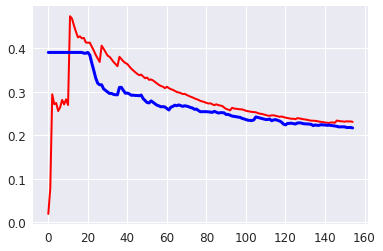

In [61]:
from sklearn.metrics import mean_squared_error

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

#plot learing curve
plot_learning_curves(final_model, X_prepared_tr, y_tr)

Seems like the train and test errors converge to a similar value; this is a sign that the model is not overfitting. Though they don't converge to a value super close to zero, it is close enough that we won't consider the model to be underfitting. 

### Model Predictions

Now that the model has been trained, let us make predictions on the hold-out test set

In [62]:
#some predictions on test set
some_data = X_te.iloc[:5]
some_labels = y_te.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", final_model.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0.27850443 0.16589484 0.3987605  0.4933378  0.4811927 ]
Labels: [0.14765907142857146, 0.19704605714285714, 0.70902336, 0.4525446304347826, 0.3762173428571429]


Seems like the model is generalizing reasonably to new data! Let us compare the train and test errors. 

In [63]:
#get predictions from train and test sets
y_train_pred = final_model.predict(X_prepared_tr)
X_prepared_te = full_pipeline.transform(X_te)
y_test_pred = final_model.predict(X_prepared_te)

#get root mean squared errors and R^2 values
print('RMSE train: %.3f, test: %.3f' % (
         np.sqrt(mean_squared_error(y_tr, y_train_pred)),
         np.sqrt(mean_squared_error(y_te, y_test_pred))) )
print('R^2 train: %.3f, test: %.3f' % (
         r2_score(y_tr, y_train_pred),
         r2_score(y_te, y_test_pred)))

RMSE train: 0.227, test: 0.212
R^2 train: 0.605, test: 0.601


Let us now plot residuals vs predicted values for both training and test sets. They should be roughly uniform.

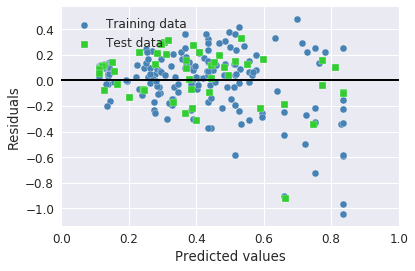

In [64]:
plt.scatter(y_train_pred,  y_train_pred - y_tr,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_te,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')

plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([0, 1])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

Let us plot predicted versus actual success on the test set

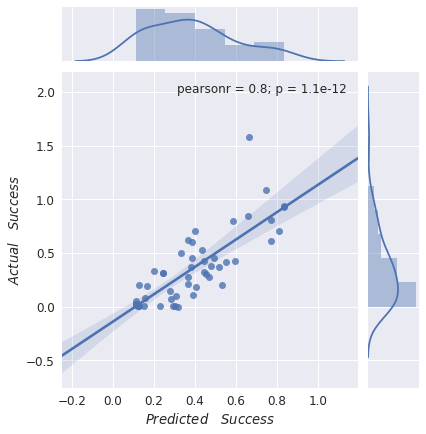

In [65]:
ax.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--', lw=4)
p=sns.jointplot(y_test_pred, y_te, kind='reg')
p.set_axis_labels(
    r'$ Predicted\quad Success$', r'$ Actual\quad Success$')

We get a Pearson coefficient is high (suggesting a positive linear correlation) so the model is performing well. Let us now explore the feature importances of the model.

In [66]:
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_names = []

#get categorical features (after one-hot-encoding)
for i in range(len(cat_var)):
    cat_names += list(cat_encoder.categories_[i])

#get list with names of all num and cat features
feature_names = num_var + cat_names

#get feature importances
feature_importances = final_model.feature_importances_

#get lists of sorted feature names and corresponding values
sorted_features = sorted(list(zip(feature_importances[range(len(feature_names))], feature_names)),
       key=lambda x: x[0], reverse=True)
sorted_features_names = [sorted_features[i][1] for i in range(len(sorted_features))]
sorted_features_values = [sorted_features[i][0] for i in range(len(sorted_features))]

#print the feature importance (value, name) pairs:
print('top 6 features: {}'.format(sorted_features[:6]))

top 6 features: [(0.31610337, 'viewership_score'), (0.25646123, 'log_budget'), (0.11133201, 'dt_main'), (0.06759443, 'dt_trailers'), (0.049701788, 'production_companies'), (0.049701788, 'Apr')]


We can also plot the feature importances

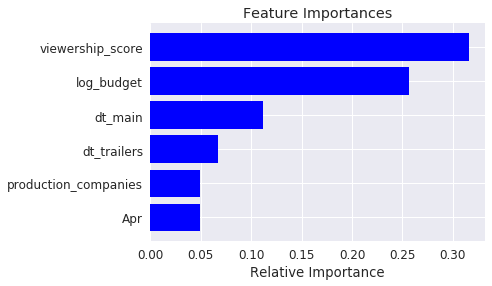

In [67]:
plt.title('Feature Importances')
plt.barh(range(6), sorted_features_values[::-1][-6:], color='b', align='center')
plt.yticks(range(6), sorted_features_names[::-1][-6:])
plt.xlabel('Relative Importance')
plt.show()

We see that the most predictive feature is the viewership score, defined as

$\ln\left(views \times search\_volume \times \frac{likes - dislikes}{likes + dislikes}\right)$